<a href="https://colab.research.google.com/github/OlaKlingberg/DTSA-5511-Final-Project-Text-Sentiment-Analysis/blob/main/Text_Sentiment_Classification_%E2%80%93_Can_we_beat_TextBlob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Sentiment Classification - Can We Beat TextBlob?**
2024-11-25

GitHub repository: [DTSA-5511-Final-Project-Text-Sentiment-Classification](https://github.com/OlaKlingberg/DTSA-5511-Final-Project-Text-Sentiment-Analysis/blob/main/Text_Sentiment_Classification_%E2%80%93_Can_we_beat_TextBlob.ipynb)

## **Introduction**
The popular Python library TextBlob provides a tool for sentiment analysis of texts. Texts are labeled on a scale from very negative (–1) to very positive (1).

In this project, I will try to create a sentiment analyzer that can beat TextBlob in accuracy, as measured on two separate datasets.
## **Data**
I will be working with two datasets
### **Dataset 1**
[Sentiment Labelled Sentences](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences) from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/) consists of a total of 3,000 reviews from Amazon, IMDB, and Yelp, which have been manually selected for being clearly positive or clearly negative; no neutral reviews are included. The dataset is perfectly balanced: there are 1,000 reviews from each of the three sources, and out of those, half are negative and half are positive. The columns are:
* **source:** amazon, imdb, or yelp; string
* **text:** the review text; string
* **label:** 0 (negative sentiment) or 1 (positive sentiment); string (which I will convert to int)

As a curated dataset without missing values, this dataset can be used without any cleaning whatsoever, but I will check whether I get better results by applying standard text-cleaning procedures, such as removing non-alpha characters.

I will call this dataset **mixed_reviews** (meaning it mixes reviews from three sources).
### **Dataset 2**
**Clothing, Shoes, and Jewelry** is a dataset available from the GitHub repository [Amazon Reviews’23](https://amazon-reviews-2023.github.io/). It contains some 278k amazon reviews pertaining to clothing, shoes, or jewelry items. This dataset has not been labeled for sentiment, but it contains the customer’s star rating, from 1 to 5, which can be used as an approximation for sentiment. There are nine columns, but I will only use these two:
* **reviewText:** the text of the review: string
* **overall:** the star-rating, 1 - 5; string (which I will convert to int)

I will call this dataset **amazon**.

I will split the labeled **mixed_reviews** dataset into a training set (80%) and a testing set (20%), and train three types of machine-learning models on the training set.
## **Models**
### [LSTM (Long Short-Term Memory)](https://en.wikipedia.org/wiki/Long_short-term_memory)

LSTMs are a type of Recurrent Neural Network (RNN) designed to process sequential data and capture long-term dependencies. Unlike traditional RNNs, LSTMs use memory cells and gates to retain relevant information over longer sequences. This makes them well-suited for sentiment analysis, where the sentiment of a sentence might depend on words appearing earlier in the text.

I will try a few different architectures, with either one or two regular LSTM layers, or a single bidirectional layer.

### [CNN (Convolutional Neural Network)](https://en.wikipedia.org/wiki/Convolutional_neural_network)
While CNNs are commonly associated with image processing, [they can also be used for text classification](https://www.geeksforgeeks.org/text-classification-using-cnn/) by treating text as a one-dimensional sequence. In text classification, CNN uses convolutional layers to extract n-gram features (i.e., phrases of length n tokens) from the text and identify these n-grams as positive or negative. CNNs are good at detecting local patterns, which is valuable for sentiment analysis.

I will explore a single architecture with one convolutional 1D layer.

### [DistilBERT (Distilled Bidirectional Encoder Representations from Transformers)](https://huggingface.co/docs/transformers/en/model_doc/distilbert)

DistilBERT is a smaller, faster (“distilled”) version of the pre-trained BERT model, which uses a transformer architecture to capture contextual relationships between words. Unlike traditional machine-learning models, transformers process entire sequences simultaneously, allowing them to understand how words influence each other. DistilBERT is pre-trained on a large corpus, giving it an understanding of language structure and semantics.

## **Embeddings**
### [GloVe (Global Vectors for Word Representation)](https://huggingface.co/docs/transformers/en/model_doc/distilbert)
GloVe embeddings are pre-trained word vectors that represent words as dense vectors in a continuous vector space. These vectors are trained on large text corpora, from which they learn the semantic relationships between words. As an example, in the GloVe embedding space, synonyms will have vectors close to each other, and the vector for “king” minus “man” plus “woman” is close to the vector for “queen.”

The DistilBERT model already has an understanding of semantics, since it is pre-trained on a large text corpus.

The LSTM and CNN models don’t in themselves have any such semantic understanding, but by using GloVe embeddings with these models, we give them a semantic understanding, similar to what the DistilBERT model has inherently.
## **Evaluation**
After training my three models on the training set from the Mixed Reviews dataset, I will test their and TextBlob’s accuracy on:
* The test set from the Mixed Reviews set.
* A random selection of reviews from the Amazon Reviews set, where I will consider 1- and 2-star reviews as being negative, and 4- and 5-star reviews as being positive. I will exclude 3-star reviews, as their sentiment presumably is neutral (or an even mix of positive and negative).


# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Installs and Imports**

In [ ]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install -q tensorflow-text

In [ ]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
!pip install -q --upgrade keras

In [ ]:
# General libraries
import numpy as np
import pandas as pd
import os
from datetime import datetime
import pytz
import json
import re
import textwrap

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split

# TextBlob
from textblob import TextBlob

# TensorFlow and Keras
import keras_core as keras
import keras_nlp
from keras_nlp.models import DistilBertPreprocessor
from keras_nlp.models import DistilBertClassifier

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Reshape, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Check versions
print(tf.__version__)
print(keras.__version__)
print(keras_nlp.__version__)

2.18.0
0.1.7
0.17.0


# **Configurations**
All configurations and model hyper-parameters are set here. This is convenient during hyper-parameter tuning.


In [ ]:
# General configs
AMAZON_SAMPLES_N   = 1000           # How many Amazon reviews to classify
CLEAN             = False           # Remove all non-alpha characters.
MODEL             = 'distilbert'    # 'lstm', 'cnn', 'distilbert', 'textblob'
MAX_SEQ_LENGTH    = 30              # Based on what we found above for the mixed-revies dataset
N_FOLDS           = 5               # Number of folds for k-fold cross-validation
LR                = 0.00002         # Learning rate. Start with cnn and lstm: 0.001; distilbert: 0.00005; textblob: N/A
BATCH             = 128             # Batch size
EPOCHS            = 30              # Number of epochs
PATIENCE          = 3               # Early-stopping patience
DROPOUT           = 0.5             # Dropout rate to overfitting

# Only for LSTM and CNN models
EMBEDDING_DIM     = 100             # Dimensionality of the GloVE vector

# Only for LSTM model
MAX_VOCAB_SIZE    = 10000
ARCHITECTURE      = 'bidirectional' # 'one_layer', 'two_layer', or 'bidirectional'
FIRST_LSTM_LAYER  = 32              # Number of units in the first LSTM layer
SECOND_LSTM_LAYER = 64              # Number of units in the second LSTM layer
ATTENTION         = True            # Include attention in the model

# Only for CNN model
NUM_FILTERS       = 128             # Number of convolutional filters
KERNEL_SIZE       = 3               # Kernel size for the convolutional filters

# Generate a timestamp, to be used in the file names of all generated files
timestamp         = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H%M')

# **Data**

In [ ]:
# Directory names

# Uncomment for submission
# MAIN_DIR = '/content/'
# DATA_DIR = os.path.join(MAIN_DIR, 'data')
# RESULTS_DIR = os.path.join(MAIN_DIR, 'results')

# Remove for submission
MAIN_DIR = '/content/drive/MyDrive/Colab/Boulder/25. Introduction to Deep Learning/Module 6. Final Project'
DATA_DIR = os.path.join(MAIN_DIR, 'data')
RESULTS_DIR = os.path.join(MAIN_DIR, 'results')

## **Mixed reviews dataset**
This is the labeled dataset with a total of 3,000 reviews from Amazon, IMDB, and Yelp, half of them negative, half of them positive.

### Import and perform basic inspection

In [ ]:
# Create an empty dataframe into which to load the data from the source files
column_names = ["source", "text", "label"]
mixed_reviews = pd.DataFrame(columns = column_names)

# The three sources
file_names = ['amazon', 'imdb', 'yelp']

# Iterate over the sources
for file_name in file_names:
    # File path to the source file
    file_path = os.path.join(DATA_DIR, 'sentiment_labeled_sentences',file_name + '.txt')

    # Read the file line by line
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Split each line into sentence and label
    mixed_reviews_data = [(file_name, line[:-2].strip(), int(line[-2])) for line in lines]

    # Create a df from the processed data
    df = pd.DataFrame(mixed_reviews_data, columns = column_names)

    # Add the df to the df for the mixed_revies df
    mixed_reviews = pd.concat([mixed_reviews, df], ignore_index = True)

# Convert the label to int (0 or 1)
mixed_reviews['label'] = mixed_reviews['label'].astype(np.int64)

# Output data dimension
print(mixed_reviews.shape, '\n')

(3000, 3) 



In [ ]:
# Output data types
print(mixed_reviews.dtypes, '\n')

source    object
text      object
label      int64
dtype: object 



In [ ]:
# Out the first few rows
mixed_reviews.head()

,source,text,label
0,amazon,So there is no way for me to plug it in here i...,0
1,amazon,"Good case, Excellent value.",1
2,amazon,Great for the jawbone.,1
3,amazon,Tied to charger for conversations lasting more...,0
4,amazon,The mic is great.,1


In [ ]:
# Check that label is 0 or 1 for all rows, and that they are balanced
mixed_reviews['label'].value_counts()

,count
label,
0,1500
1,1500


### Text lengths

I add a column for word count and show its distribution.

In [ ]:
# Add a column for word count
mixed_reviews['word_count'] = mixed_reviews['text'].apply(lambda x: len(x.split()))
mixed_reviews.head()

,source,text,label,word_count
0,amazon,So there is no way for me to plug it in here i...,0,21
1,amazon,"Good case, Excellent value.",1,4
2,amazon,Great for the jawbone.,1,4
3,amazon,Tied to charger for conversations lasting more...,0,11
4,amazon,The mic is great.,1,4


The longest review has 71 words.
Mean length: 11.8
Median length: 10
95th percentile length: 26
97th percentile length: 29. Based on this, I'll set the Max Sequence Length to 30.


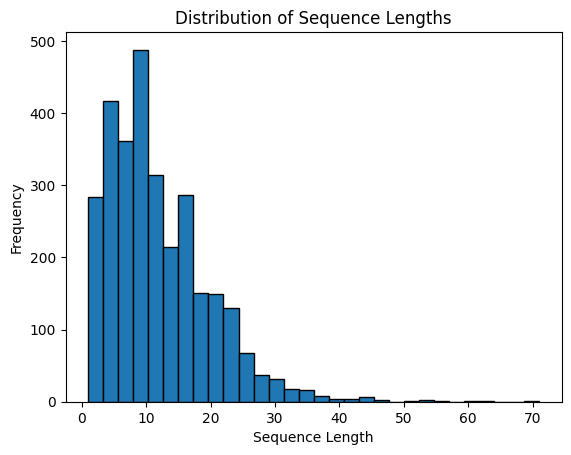

In [ ]:
# Show distribution of word counts: mr stands for "mixed_reviews"
mr_word_counts = mixed_reviews['word_count']

mr_max_length = max(mr_word_counts)
print(f"The longest review has {mr_max_length} words.")
print(f"Mean length: {np.mean(mr_word_counts):.1f}")
print(f"Median length: {np.median(mr_word_counts):.0f}")
print(f"95th percentile length: {np.percentile(mr_word_counts, 95):.0f}")
print(f"97th percentile length: {np.percentile(mr_word_counts, 97):.0f}. Based on this, I'll set the Max Sequence Length to 30.")

plt.hist(mr_word_counts, bins=30, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

### Examine some sampled texts
Let's look at a sample of reviews from each source (Amaxon, IMDB, Yelp) and of each class (0 = negative sentiment; 1 = positive sentiment).

Note: I consider the first sample in IMDB class 1 mislabeled. It does mention that a certain scene is cool, but it does so in order to make a negative statement about the movie as a whole ("the only scene in the movie that was cool ...")


In [ ]:
# The three sources of the mixed_reviews
sources = ['amazon', 'imdb', 'yelp']

# Iterate over the three sources
for source in sources:
    # Iterate over the two labels
    for label in [0, 1]:
        # Output the source and the label
        print(f"{source}. Class: {label}.")
        # Iterate over and output the first five reviews of the current source and label
        for i, review in enumerate(mixed_reviews[(mixed_reviews['source'] == source) & (mixed_reviews['label'] == label)] \
                                .sample(5, random_state = 42).iterrows()):
            print(f"{i + 1}, {review[1]['text']}")
        print()

amazon. Class: 0.
1, Bought mainly for the charger, which broke soon after purchasing.
2, Audio Quality is poor, very poor.
3, I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good
4, AMAZON SUCKS.
5, I also didn't like the "on" button, it felt like it would crack with use.

amazon. Class: 1.
1, Appears to actually outperform the original battery from China that came with my V325i.
2, !I definitly recommend!!
3, T-Mobile has the best customer service anywhere.
4, This is hands down the best phone I've ever had.
5, great headset, very impressed - H500.

imdb. Class: 0.
1, The least said about the acting the better.
2, The only possible way this movie could be redeemed would be as MST3K fodder.
3, It is a film about nothing, just a pretext to show ridiculous action scenes.
4, The concert sequences just sucked.
5, I'll even say it again  this is torture.

imdb. Class: 1.
1, PS the only scene in the movie that was cool is when the central char

## **Amazon reviews dataset**
This is the set of some 278k Amazon reviews pertaining to clothing, shoes, or jewelry. The data is unlabled, but contains the customer's star rating (1 - 5).


### Import the data and select the relevant columns

In [ ]:
AMAZON_FILENAME = 'reviews_Clothing_Shoes_and_Jewelry_5.json'
file_path = os.path.join(DATA_DIR, AMAZON_FILENAME)

# Read the .json.gz file
amazon_full_set = pd.read_json(file_path, lines=True)

# Output dimensions
amazon_full_set.shape

(278677, 9)

In [ ]:
# Output the first few rows
amazon_full_set.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [ ]:
# Extract the reviewText and the star rating (called 'overall') and rename them
amazon_full_set = amazon_full_set[['reviewText', 'overall']]
amazon_full_set.columns = ['text', 'star_rating']

### Take a subset of the data
This dataset will only be used to test the models, not to train them. It's therefore sufficient to use a small subset. In the **CONFIGURATION** above, I've set AMAZON_SAMPLES_N to 1,000, which means we will get 200 reviews of each star rating. I will only use those with 1 or 2 stars (negative) or 4 or 5 stars (positive). I will exclude 3-star reviews.

In [ ]:
# The number of reviews to take from each rating (1 to 5)
samples_per_rating = int(AMAZON_SAMPLES_N / 5)

# Get a balanced sample, i.e. with the same number of reviews from each rating (1 to 5)
balanced_sample = amazon_full_set.groupby('star_rating').sample(n = samples_per_rating, random_state = 42)

# Shuffle the df and name it just "amazon"
amazon = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Sanity check: verify that the there is the same number for each rating
print(amazon['star_rating'].value_counts())

star_rating
3    200
4    200
5    200
1    200
2    200
Name: count, dtype: int64


### Text lengths

In [ ]:
# Add a column for word count
amazon['word_count'] = amazon['text'].apply(lambda x: len(x.split()))

The longest review has 849 words.
Mean length: 64.0
Median length: 43
95th percentile length: 179
97th percentile length: 230.


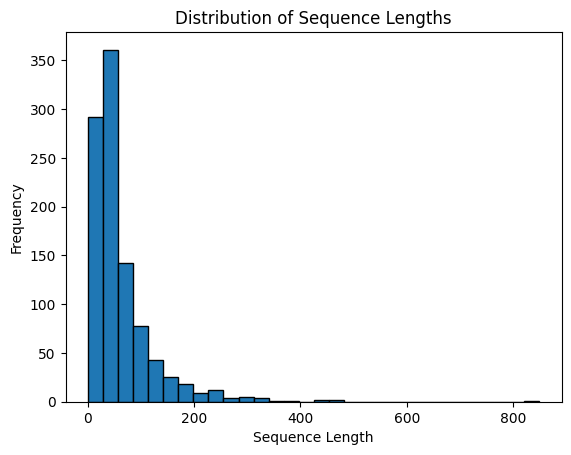

In [ ]:
# Show distribution of word counts
amazon_word_counts = amazon['word_count']

amazon_max_length = max(amazon_word_counts)
print(f"The longest review has {amazon_max_length} words.")
print(f"Mean length: {np.mean(amazon_word_counts):.1f}")
print(f"Median length: {np.median(amazon_word_counts):.0f}")
print(f"95th percentile length: {np.percentile(amazon_word_counts, 95):.0f}")
print(f"97th percentile length: {np.percentile(amazon_word_counts, 97):.0f}.")

plt.hist(amazon_word_counts, bins=30, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

### Examine some sampled texts
Let's look at a sample of reviews for each star rating. The 1- and 2-star reviews are indeed negative, and the 4- and 5-star reviews are positive.

I do not display the 3-star reviews, as I will not use them.


In [ ]:
# Take a look at some reviews of each star rating

# Iterate over the ratings (1 to 5)
for rating in [1, 2, 4, 5]:
    print(f"Star rating: {rating}")
    # Iterate over a sample of 5 reviews from the current rating
    for i, review in enumerate(amazon[amazon['star_rating'] == rating].sample(5, random_state = 42).iterrows()):
        # Wrap the text. (Otherwise it's output as one very long line.)
        wrapped_text = textwrap.fill(review[1]['text'], width=80)
        print(f"Review {i + 1}. {wrapped_text}")
        print()
    print("-" * 80)

Star rating: 1
Review 1. I ordered the pink one, which I returned within 2 days! Too light, which is an
advantage but see-through material! Need to use an inner! The neckline is too
deep... Doesn't go well even with a bra! too expensive for the material.

Review 2. The concept of this was good...made sense but when I received it, it's very
bulky. The material is heavy weight, and when you pull the drawstring, there is
an excess that is supposed to be stuffed inside the pocket on the front. I found
it to be just to inconvenient. It is a good concept but very high priced...

Review 3. I know everything in the world but this is not any good to send in a holster and
not in a box that no

Review 4. The beanie is stiff, not slouchy! No amount of washing or working with the
fabric made it slouch. I'm really annoyed because I could have just gone to
walmart and saved the time and aggravation of being mislead.

Review 5. It was terrible fit. Super huge, the material was odd and it wasn't flatte

# **Data Cleaning**

## **Check for duplicates**

As we see below, there are 18 non-unique texts in the **mixed_reviews** dataset, but there are no non-unique texts with different labels, i.e. if there are two (or more) reviews with the same text, they also have the same label.

If there had been non-unique texts with conflicting labels, it would have been wise to remove those reviews (or relabel them manually), since they would constitute noise rather than information. Since this is not the case, I will keep the duplicates, based on the reasoning that a text that appears twice in the data should carry more weight for the training of the model than a text that appears only once.

There are no non-unique texts in the **Amazon** dataset.





In [ ]:
def find_duplicates(df, label_col_name):

    # Display any duplicate rows based on the 'text' column
    duplicates = df[df['text'].duplicated()]

    # Print a few duplicates
    if len(duplicates):
        print("Examples of duplicates")
        print(duplicates[['text']].sort_values(by = 'text').head())
        print()

    # Total number of duplicates
    print(f"There are {len(duplicates)} non-unique texts.")

    # Find duplicate tweets with different labels
    conflicting_duplicates = df.groupby('text')[label_col_name].nunique().reset_index()
    conflicting_duplicates = conflicting_duplicates[conflicting_duplicates[label_col_name] > 1]

    # How many
    print(f"There are {len(conflicting_duplicates)} non-unique texts that have different labels.")

print("Mixed reviews dataset")
find_duplicates(mixed_reviews, 'label')

Mixed reviews dataset
Examples of duplicates
                                  text
1788                             10/10
1363    Definitely worth checking out.
748                      Does not fit.
543            Don't buy this product.
892   Excellent product for the price.

There are 18 non-unique texts.
There are 0 non-unique texts that have different labels.


In [ ]:
print("\nAmazon dataset")
find_duplicates(amazon, 'star_rating')


Amazon dataset
There are 0 non-unique texts.
There are 0 non-unique texts that have different labels.


## **Remove non-alpha characters**
I will test two cleaning options during training, to see which leads to better results:
* **Don't clean:** the texts are left as they are.
* **Clean:** remove non-alpha characters, and lowercase the text.

In [ ]:
if CLEAN:
    # Remove all non-alpha characters. Convert to lower case
    mixed_reviews['text'] = mixed_reviews['text'].str.replace(r'[^a-zA-Z\s]', '', regex = True).str.lower()
    amazon['text'] = amazon['text'].str.replace(r'[^a-zA-Z\s]', '', regex = True).str.lower()

# **Split Data into Training and Test Sets**
I will use 80% of the **mixed_reviews** dataset for training and the remaining 20% as one of my two test sets (the other test set being the entire **Amazon** review dataset).

The training set will later on be further split into training and validation sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mixed_reviews["text"],
                                                                    mixed_reviews["label"],
                                                                    test_size = 0.2,
                                                                    stratify = mixed_reviews["label"],
                                                                    random_state = 42)

# We need to reset the indices for kf.split (used further down) to work
X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)

# **Custom Callback Class for Performance Metrics**
An instance of this custom callback class will be used to save performance metrics from all epochs during all folds of the k-fold cross-validation training. I will output some graphs of these metrics, which will be useful when tuning hyper-parameters.


In [ ]:
# Custom callback class to store metrics at the end of each epoch
class MetricsHistory(Callback):
    def __init__(self, training_data = None, validation_data=None):
        super(MetricsHistory, self).__init__()
        self.training_data = training_data
        self.validation_data = validation_data
        self.epochs = []
        self.accuracy = []
        self.val_accuracy = []
        self.precision = []
        self.val_precision = []
        self.recall = []
        self.val_recall = []
        self.f1 = []
        self.val_f1 = []
        self.loss = []
        self.val_loss = []

    # On the end of each epoch, calculate and save performance metrics
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch)

        # Save loss. Loss is computed automatically
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

        # Save accuracy. Accuracy is computed automatically
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

        # Make predictions on the training data
        y_pred_train = self.model.predict(self.training_data[0])
        y_true_train = self.training_data[1]

        # Convert predictions on training data to binary
        try:
            y_pred_train_binary = (y_pred_train[:, 1] >= 0.5).astype(int) # For DistilBert
        except:
            y_pred_train_binary = (y_pred_train >= 0.5).astype(int) # For LSTM

        # Calculate precision, recall, f1 for training data
        train_precision = precision_score(y_true_train, y_pred_train_binary)
        train_recall = recall_score(y_true_train, y_pred_train_binary)
        train_f1 = f1_score(y_true_train, y_pred_train_binary)

        # Store precision, recall, f1 for training data
        self.precision.append(train_precision)
        self.recall.append(train_recall)
        self.f1.append(train_f1)

        # Make predictions on the validation data
        y_pred_val = self.model.predict(self.validation_data[0])
        y_true_val = self.validation_data[1]

        # Convert predictions on validation data to binary
        try:
            y_pred_val_binary = (y_pred_val[:, 1] >= 0.5).astype(int) # For DistilBert
        except:
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int) # For LSTM

        # Calculate precision, recall, f1 for validation data
        val_precision = precision_score(y_true_val, y_pred_val_binary)
        val_recall = recall_score(y_true_val, y_pred_val_binary)
        val_f1 = f1_score(y_true_val, y_pred_val_binary)

        # Store precision, recall, f1 for validation data
        self.val_precision.append(val_precision)
        self.val_recall.append(val_recall)
        self.val_f1.append(val_f1)

# **Main Wrapper Class**
I will wrap the model in this class, which has methods for building and training the model, running k-fold cross-validation, and for evaluating the model on test data.

To keep the workflow consistent, I will use this class to wrap TextBlob too, even though TextBlob does not require any training.

In [ ]:
#load_ext lab_black
class SentimentAnalysis:
    def __init__(self, model_type, texts, labels):
        print(f"Creating a wrapper for model {model_type}")

        self.cumulative_confusion_matrix = np.zeros((2, 2))  # Binary classifier, so 2 x 2 confusion matrix.
        self.embedding_index = {}
        self.embedding_matrix = None
        self.epoch_metrics = {
            'accuracy': [],
            'val_accuracy': [],
            'precision': [],
            'val_precision': [],
            'recall': [],
            'val_recall': [],
            'f1': [],
            'val_f1': [],
            'loss': [],
            'val_loss': []
        }
        self.labels = labels
        self.metrics_history = None
        self.model_type = model_type
        self.padded_sequences = None
        self.texts = texts
        self.tokenizer = None

        # LSTM and CNN require tokenization and an embedding matrix.
        if model_type in ['lstm', 'cnn']:
            self.tokenize()
            self.make_embedding_matrix()
        elif model_type == 'distilbert':
            pass
        elif model_type == 'textblob':
            pass
        else:
            raise ValueError("Model type must be 'lstm', 'cnn', 'distilbert', or 'textblob'.")

    # Tokenize
    def tokenize(self):
        # Tokenize the text data
        self.tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
        self.tokenizer.fit_on_texts(self.texts)

        # Convert text to sequences of integers and pad
        sequences = self.tokenizer.texts_to_sequences(self.texts)

        self.padded_sequences = pad_sequences(sequences, maxlen = MAX_SEQ_LENGTH)

    def make_embedding_matrix(self):
        # Load GloVe embeddings
        with open(os.path.join(DATA_DIR, 'glove.6B.100d.txt'), encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embedding_index[word] = coefs

        print(f'Found {len(self.embedding_index)} word vectors.')

        # Prepare the embedding matrix
        self.embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
        for word, i in self.tokenizer.word_index.items():
            if i < MAX_VOCAB_SIZE:
                embedding_vector = self.embedding_index.get(word)
                if embedding_vector is not None:
                    # Words not found in embedding_index will be all-zeros
                    self.embedding_matrix[i] = embedding_vector

    # Build the LSTM model
    def build_lstm_model(self):
        model = Sequential()

        # Add the Input layer separately
        model.add(Input(shape=(MAX_SEQ_LENGTH,)))

        # Add the embedding layer
        model.add(Embedding(input_dim = MAX_VOCAB_SIZE,
                            output_dim = EMBEDDING_DIM,
                            weights = [self.embedding_matrix],
                            trainable = False))  # Set trainable=False to use pretrained embeddings

        # Add layers based on selected model architecture
        if ARCHITECTURE == 'one_layer':
            model.add(LSTM(FIRST_LSTM_LAYER, return_sequences=False))  # Single LSTM layer
        elif ARCHITECTURE == 'two_layer':
            model.add(LSTM(FIRST_LSTM_LAYER, return_sequences=True))  # First LSTM layer returns full sequence
            model.add(LSTM(SECOND_LSTM_LAYER, return_sequences=False))  # Second LSTM layer
        elif ARCHITECTURE == 'bidirectional':
            model.add(Bidirectional(LSTM(FIRST_LSTM_LAYER)))  # Bidirectional LSTM
        else:
            raise ValueError("Invalid architecture. Choose from 'one_layer', 'two_layer', or 'bidirectional'.")

        # Add the dropout and activation layers.
        model.add(Dropout(DROPOUT)) # Add a Dropout layer for regularization
        model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

        self.model = model

    # Build the CNN model
    def build_cnn_model(self):
        model = Sequential()

        # Add the Input layer
        model.add(Input(shape=(MAX_SEQ_LENGTH,)))

        # Add the embedding layer
        model.add(Embedding(input_dim = MAX_VOCAB_SIZE,
                            output_dim = EMBEDDING_DIM,
                            weights = [self.embedding_matrix],
                            trainable = False))  # Using pre-trained embeddings

        # Add a Conv1D layer
        model.add(Conv1D(filters = NUM_FILTERS,
                        kernel_size = KERNEL_SIZE,
                        activation = 'relu'))

        # Pooling layer
        model.add(GlobalMaxPooling1D())

        # Add a dropout layer for regularization
        model.add(Dropout(DROPOUT))

        # Add a dense layer with a sigmoid activation for binary classification
        model.add(Dense(1, activation='sigmoid'))

        self.model = model

    # Build the DistilBert model
    def build_distilbert_model(self):
        AUTO = tf.data.experimental.AUTOTUNE

        # Specify DistilBERT preset
        preset= "distil_bert_base_en_uncased"

        # DistilBERT preprocessor
        preprocessor = DistilBertPreprocessor.from_preset(preset,
                                                          sequence_length = 160,
                                                          name = "distil_bert_base_en_uncased")

        # DistilBERT model
        self.model = DistilBertClassifier.from_preset(preset,
                                                      preprocessor = preprocessor,
                                                      num_classes = 2)

    # Run k-fold cross validation
    def k_fold_cross_validation(self):
        if self.model_type == 'textblob':
            print('No training needed for for the TextBlob model.')
            return

        X = self.texts
        y = self.labels

        # Get the folds
        kf = KFold(n_splits = N_FOLDS, shuffle=True, random_state=42)

        # Training loop for K-fold cross-validation
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            print(f"\nFold {fold + 1}")

            # Clear the previous model to avoid memory issues
            K.clear_session()

            # Early stopping
            early_stopping = EarlyStopping(monitor='val_loss',
                                           patience = PATIENCE,
                                           restore_best_weights = True)

            # Prepare texts for LSTM and CNN models
            if self.model_type in ['lstm', 'cnn']:
                self.tokenize()

                # Split the data formatted for LSTM and CNN into training and validation sets
                X_train, X_val = self.padded_sequences[train_index], self.padded_sequences[val_index]
                y_train, y_val = y[train_index], y[val_index]

            # LSTM model
            if self.model_type == 'lstm':
                # Convert to NumPy array.
                if isinstance(y_train, pd.Series):
                    y_train = y_train.values

                # Build the model
                self.build_lstm_model()

                # Define the optimizer with a custom learning rate
                optimizer = Adam(learning_rate = LR)

                # Compile
                self.model.compile(optimizer = optimizer,
                                   loss = 'binary_crossentropy',
                                   metrics = ['accuracy'])

                # Instantiate custom callback to save performance metrics during training
                metrics_history = MetricsHistory(training_data = (X_train, y_train),
                                                 validation_data = (X_val, y_val))

                # Train the model
                self.model.fit(X_train, y_train,
                               epochs = EPOCHS,
                               batch_size = BATCH,
                               validation_data = (X_val, y_val),
                               callbacks = [metrics_history, early_stopping])

            # CNN model
            elif self.model_type == 'cnn':
                self.build_cnn_model()

                # Compile
                self.model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
                                   loss = 'binary_crossentropy',
                                   metrics = ['accuracy'])

                # Instantiate custom callback to save performance metrics during training
                metrics_history = MetricsHistory(training_data = (X_train, y_train),
                                                 validation_data = (X_val, y_val))

                # Train the model
                self.model.fit(x = X_train, y = y_train,
                               batch_size = BATCH,
                               epochs = EPOCHS,
                               validation_data = (X_val, y_val),
                               callbacks = [metrics_history, early_stopping])

            # DistilBert model
            elif self.model_type == 'distilbert':
                # tokenizer = None

                # Split the data formatted for DistilBert into training and validation sets
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                # Build model
                self.build_distilbert_model()

                # Compile
                self.model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                                   optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
                                   metrics= ["accuracy"])

                # Instantiate custom callback to save performance metrics during training
                metrics_history = MetricsHistory(training_data = (X_train, y_train), validation_data = (X_val, y_val))

                # Train the model using raw text and labels, with validation data created from train_test_split
                bert_history = self.model.fit(x=X_train, y=y_train,
                                              batch_size = BATCH,
                                              epochs = EPOCHS,
                                              validation_data=(X_val, y_val),
                                              callbacks=[metrics_history, early_stopping])

            else:
                raise ValueError("Invalid model type. Choose from 'lstm' or 'distilbert', 'cnn'.")

            # Print the model summary only once
            if fold == 0:
                self.model.summary()

            # Append metrics for this fold to the epoch_metrics dictionary
            self.epoch_metrics['accuracy'].append(metrics_history.accuracy)
            self.epoch_metrics['val_accuracy'].append(metrics_history.val_accuracy)
            self.epoch_metrics['precision'].append(metrics_history.precision)
            self.epoch_metrics['val_precision'].append(metrics_history.val_precision)
            self.epoch_metrics['recall'].append(metrics_history.recall)
            self.epoch_metrics['val_recall'].append(metrics_history.val_recall)
            self.epoch_metrics['f1'].append(metrics_history.f1)
            self.epoch_metrics['val_f1'].append(metrics_history.val_f1)
            self.epoch_metrics['loss'].append(metrics_history.loss)
            self.epoch_metrics['val_loss'].append(metrics_history.val_loss)

            # Predict on the validation set
            y_pred_val = self.model.predict(X_val)

            # Convert predictions to binary
            if MODEL == 'distilbert':
                y_pred_val_binary = (y_pred_val[:, 1] >= 0.5).astype(int) # For DistilBert
            else:
                y_pred_val_binary = (y_pred_val >= 0.5).astype(int) # For LSTM and CNN

            # Generate and save a confusion matrix
            fold_confusion_matrix = confusion_matrix(y_val, y_pred_val_binary)
            self.cumulative_confusion_matrix += fold_confusion_matrix

        print(f"\nCompleted {N_FOLDS}-fold cross validation!")

    # Due to early stopping, different folds may run different number of epochs.
    # We therefore pad the list of epochs with NaN so they are the same length for each fold.
    def pad_fold_epoch_lists(self, metric_list):
        """Pads each list in metric_list with NaN to ensure equal length."""
        padded_metrics = []

        # Find the maximum number of epochs across all folds
        max_epochs = max(len(acc) for acc in self.epoch_metrics['accuracy'])

        for seq in metric_list:
            if len(seq) < max_epochs:
                # Pad the sequence with NaN to make them equal length
                seq = seq + [np.nan] * (max_epochs - len(seq))
            padded_metrics.append(seq)

        return padded_metrics

    def average_metrics_across_folds(self):
        # Pad all metric lists to ensure they have the same length
        self.epoch_metrics['accuracy'] = self.pad_fold_epoch_lists(self.epoch_metrics['accuracy'])
        self.epoch_metrics['val_accuracy'] = self.pad_fold_epoch_lists(self.epoch_metrics['val_accuracy'])
        self.epoch_metrics['precision'] = self.pad_fold_epoch_lists(self.epoch_metrics['precision'])
        self.epoch_metrics['val_precision'] = self.pad_fold_epoch_lists(self.epoch_metrics['val_precision'])
        self.epoch_metrics['recall'] = self.pad_fold_epoch_lists(self.epoch_metrics['recall'])
        self.epoch_metrics['val_recall'] = self.pad_fold_epoch_lists(self.epoch_metrics['val_recall'])
        self.epoch_metrics['f1'] = self.pad_fold_epoch_lists(self.epoch_metrics['f1'])
        self.epoch_metrics['val_f1'] = self.pad_fold_epoch_lists(self.epoch_metrics['val_f1'])
        self.epoch_metrics['loss'] = self.pad_fold_epoch_lists(self.epoch_metrics['loss'])
        self.epoch_metrics['val_loss'] = self.pad_fold_epoch_lists(self.epoch_metrics['val_loss'])

        # Average the metrics across all folds for each epoch, ignoring NaN values
        average_metrics = {
            'accuracy': np.nanmean(self.epoch_metrics['accuracy'], axis=0),
            'val_accuracy': np.nanmean(self.epoch_metrics['val_accuracy'], axis=0),
            'precision': np.nanmean(self.epoch_metrics['precision'], axis=0),
            'val_precision': np.nanmean(self.epoch_metrics['val_precision'], axis=0),
            'recall': np.nanmean(self.epoch_metrics['recall'], axis=0),
            'val_recall': np.nanmean(self.epoch_metrics['val_recall'], axis=0),
            'f1': np.nanmean(self.epoch_metrics['f1'], axis=0),
            'val_f1': np.nanmean(self.epoch_metrics['val_f1'], axis=0),
            'loss': np.nanmean(self.epoch_metrics['loss'], axis=0),
            'val_loss': np.nanmean(self.epoch_metrics['val_loss'], axis=0)
        }

        # self.average_metrics = average_metrics

        return average_metrics

    # Some texts in the Amazon dataset (which I will use as one of my two test sets)
    # are much longer then the max 30 tokens I use when training the models
    # (which is based on the 97th percentile for the lengths of texts in the training set).
    # To base the predictions on the entire text of such longer reeviews,
    # I split them into chunks, predict on each chunk, and then weigh the predictions
    # on the chunks to generate a final prediction for the text as a whole.
    def split_longer_text(self, text):
        # I will split on periods, question marks, and explanation points,
        # since those punctuation marks indicate the end of sentence.
        # I will not split on the period in these common abbrevations.
        abbreviations = {"mr.", "mrs.", "dr.", "e.g.", "i.e.", "u.s.", "etc.", "vs."}

        # Function to check if a sentence ends with an abbreviation
        def ends_with_abbreviation(sentence):
            words = sentence.strip().split()
            if words and words[-1].lower() in abbreviations:
                return True
            return False

        # Regular expression pattern to split on . ? !
        sentence_endings = re.compile(r'(?<=[.?!])\s+')

        all_chunks = []  # List to store all chunks

        # Split the text into sentences
        sentences = sentence_endings.split(text)

        # Combine sentences into chunks, keeping track of word count
        current_chunk = []
        current_word_count = 0

        for i, sentence in enumerate(sentences):
            words = sentence.split()  # Split sentence into words
            # Check if this sentence ends with an abbreviation
            if ends_with_abbreviation(sentence) and i < len(sentences) - 1:
                # If it ends with an abbreviation, don't split here; combine with next
                if current_chunk:
                    current_chunk.extend(words)
                    current_word_count += len(words)
                continue  # Skip splitting here

            if current_word_count + len(words) > MAX_SEQ_LENGTH:
                if current_chunk:
                    # Save the current chunk
                    all_chunks.append(' '.join(current_chunk))
                # Start a new chunk
                current_chunk = words[:]
                current_word_count = len(words)
            else:
                # Add the sentence to the current chunk
                current_chunk.extend(words)
                current_word_count += len(words)

        # Save the last chunk if it exists
        if current_chunk:
            all_chunks.append(' '.join(current_chunk))

        return all_chunks

    # Add two columns to the dataset:
    # pred_prob is the probability that the text belongs to class 1,
    # or, for TextBlob, the sentiment score rescaled to the range [0, 1].
    def add_predictions(self, df):
        if MODEL == 'textblob':
            # Transform from [-1, 1] to [0, 1]
            df['pred_prob'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity) * 0.5 + 0.5
            df['pred_label'] = df['pred_prob'].apply(lambda x: 1 if x > 0.5 else 0 if x < 0.5 else np.nan)

        else:
            # Iterate over each review in the dataframe
            for review in df.iterrows():
                index = review[0]
                text = review[1]['text']

                # Split longer texts into shorter, to fit within max_sequence_length
                chunks = self.split_longer_text(text)

                # Convert predictions to binary
                if MODEL in ['lstm', 'cnn']:
                    X_sequences = self.tokenizer.texts_to_sequences(chunks)
                    X_padded = pad_sequences(X_sequences, maxlen = MAX_SEQ_LENGTH)

                    # Use the trained model to predict on the new data
                    probs = self.model.predict(X_padded, verbose = 0)

                else:
                    # Use the trained model to predict on the new data
                    y_pred = self.model.predict(chunks, verbose = 0)
                    prob_pairs = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
                    probs = prob_pairs[:, 1]

                prob = np.mean(probs)
                df.loc[index, 'pred_prob'] = prob
                df.loc[index, 'pred_label'] = 1 if prob > 0.5 else 0

        # If prob is exactly 0.5 (which often happens for TextBlob), set the label to NaN.
        df.loc[df['pred_prob'] == 0, 'pred_label'] = np.nan

        return df

# **Plot-Generating Functions**
These functions are used for outputting and saving plots.
* **plot_metrics_across_epochs** generates and saves five plots to show how training and validation loss, accuracy, recall, precision, and F1-score change across the epochs. (It averages these numbers across the folds in k-fold cross-validation.) These plots are useful for determining if the the models converge properly, and if they overfit the training data. I will use these plots when tuning model architecture and hyper-parameters.
* **generate_confusion_matrix** generates and saves a confusion matrix.


In [ ]:
def plot_metrics_across_epochs(average_metrics, timestamp):
    epochs = [*range(len(average_metrics['accuracy']))]

    plt.figure(figsize=(12, 7))

    # Loss plot
    plt.subplot(2, 3, 1)
    plt.plot(epochs, average_metrics['loss'], label='Training Loss')
    plt.plot(epochs, average_metrics['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 3, 2)
    plt.plot(epochs, average_metrics['accuracy'], label='Training Accuracy')
    plt.plot(epochs, average_metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Precision plot
    plt.subplot(2, 3, 4)
    plt.plot(epochs, average_metrics['precision'], label='Training Precision')
    plt.plot(epochs, average_metrics['val_precision'], label='Validation Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Recall plot
    plt.subplot(2, 3, 5)
    plt.plot(epochs, average_metrics['recall'], label='Training Recall')
    plt.plot(epochs, average_metrics['val_recall'], label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # F1 plot
    plt.subplot(2, 3, 6)
    plt.plot(epochs, average_metrics['f1'], label='Training F1 Score')
    plt.plot(epochs, average_metrics['val_f1'], label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    plt.tight_layout()

    # Save the plot with a unique timestamp
    metrics_plots_f = f'metrics_plots_{timestamp}.png'

    # Save the plot.
    plt.savefig(os.path.join(RESULTS_DIR, metrics_plots_f))

    plt.draw()
    plt.show()

In [ ]:
def generate_confusion_matrix(true_label, pred_label, dataset_name):
    cm = confusion_matrix(true_label, pred_label)

    disp = ConfusionMatrixDisplay(cm.astype(int)).plot(cmap = 'Blues')
    disp.plot(cmap = 'Blues')

    # Save the plot with a unique timestamp
    cm_filename = f'cm_for_{dataset_name}_{timestamp}.png'

    file_path = os.path.join(RESULTS_DIR, cm_filename)

    # Save the plot to disk
    plt.savefig(file_path, bbox_inches='tight')  # 'bbox_inches' ensures the entire plot is saved
    plt.close()

# **Build and Train the Model**

In [ ]:
# Generate a wrapper for the selected model type
model_wrapper = SentimentAnalysis(MODEL, X_train, y_train)

Creating a wrapper for model distilbert


In [ ]:
# Perform k-fold cross-validation on the training set.
# TextBlob requires no training, so no need for cross-validation.
if MODEL != 'textblob':
    model_wrapper.k_fold_cross_validation()


Fold 1


100%|██████████| 515/515 [00:00<00:00, 629kB/s]


100%|██████████| 580/580 [00:00<00:00, 726kB/s]


100%|██████████| 226k/226k [00:00<00:00, 294kB/s]


100%|██████████| 253M/253M [00:18<00:00, 14.8MB/s]


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5840 - loss: 0.6831 - val_accuracy: 0.8854 - val_loss: 0.5767
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 984ms/step - accuracy: 0.8877 - loss: 0.5092 - val_accuracy: 0.9229 - val_loss: 0.2693
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9219 - loss: 0.2595 - val_accuracy: 0.9250 - val_loss: 0.1976
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9552 - loss: 0.1542 - val_accuracy: 0.9396 - val_loss: 0.1816
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1000ms/step - accuracy: 0.9779 - loss: 0.0976 - val_accuracy: 0.9354 - val_loss: 0.1976
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/

Preprocessor: "distil_bert_base_en_uncased"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 200,865,032 (766.24 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,910,022 (510.83 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Fold 2
Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5273 - loss: 0.6846 - val_accuracy: 0.8792 - val_loss: 0.5912
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8862 - loss: 0.5323 - val_accuracy: 0.9062 - val_loss: 0.3114
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9229 - loss: 0.2740 - val_accuracy: 0.9167 - val_loss: 0.2217
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9563 - loss: 0.1627 - val_accuracy: 0.9208 - val_loss: 0.2243
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9722 - loss: 0.1087 - val_accuracy: 0.9271 - val_loss: 0.2124
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6177 - loss: 0.6757 - val_accuracy: 0.8875 - val_loss: 0.5311
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9004 - loss: 0.4634 - val_accuracy: 0.9062 - val_loss: 0.2749
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9266 - loss: 0.2382 - val_accuracy: 0.9167 - val_loss: 0.2191
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9615 - loss: 0.1410 - val_accuracy: 0.9250 - val_loss: 0.2156
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 999ms/step - accuracy: 0.9756 - loss: 0.0847 - val_accuracy: 0.9333 - val_loss: 0.2130
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5902 - loss: 0.6836 - val_accuracy: 0.7417 - val_loss: 0.5983
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8030 - loss: 0.5415 - val_accuracy: 0.9083 - val_loss: 0.3108
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9207 - loss: 0.2775 - val_accuracy: 0.9229 - val_loss: 0.2086
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9490 - loss: 0.1711 - val_accuracy: 0.9312 - val_loss: 0.1754
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 997ms/step - accuracy: 0.9662 - loss: 0.1138 - val_accuracy: 0.9333 - val_loss: 0.1619
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6063 - loss: 0.6793 - val_accuracy: 0.8646 - val_loss: 0.5515
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8979 - loss: 0.4786 - val_accuracy: 0.8896 - val_loss: 0.3095
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9336 - loss: 0.2329 - val_accuracy: 0.9125 - val_loss: 0.2491
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9608 - loss: 0.1379 - val_accuracy: 0.9333 - val_loss: 0.2247
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 996ms/step - accuracy: 0.9788 - loss: 0.0841 - val_accuracy: 0.9250 - val_loss: 0.2441
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
15/15 ━

# **Training Performance Metrics**
These plots show how some important performance metrics change across the epochs during training. (The numbers are averaged across the folds of the k-fold cross validation.) These plots are useful when deciding what hyper-parameter to tweak next.

In this case, the graphs show some sign of overfitting, especially the Loss and Accuracy graphs, where the validation metrics start getting worse while the training metrics keep improving.




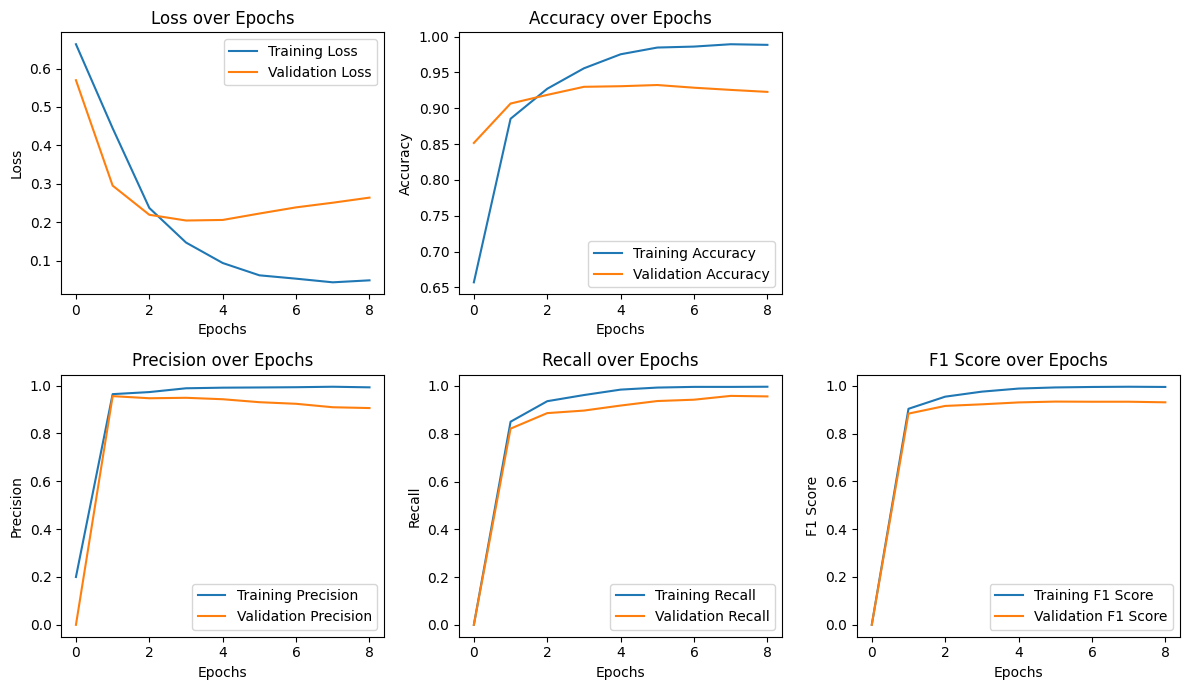

In [ ]:
# Plots showing how the performance metrics change across the epochs.
# The numbers are averaged across the folds in the k-folds cross-validation.
if MODEL != 'textblob':
    average_metrics = model_wrapper.average_metrics_across_folds()
    # Plot metrics over epochs
    plot_metrics_across_epochs(average_metrics, timestamp)

# **Evaluate the Models on the Two Test Sets**

## **Test set 1. The hold-out set from mixed_reviews**

We generated X_test and y_test from the mixed_reviews dataset earlier in the notebook. We will now have to take the unsual step of merging X_test and y_test back into one dataframe. The reason is this:

While the LSTM, CNN, and DistilBERT models are unlikely to output predictions of exactly 0.5 (i.e. right on the decision border between positive and negative), TextBlob quite often gives a sentiment score of 0. On the TextBlob range from -1 (very negative) to 1 (very positive), 0 means neuteral, and is what we will use as the decision boundary. Since I handle this as a binary classification task, I will have to filter out those reviews where the predicion is neither positive nor negative.

It's to enabling this filtering that I merge X_test and y_test into one dataframe. After predicting on X_text, we can then drop rows where the prediction is neuteral.

Two columns are added during prediction:
* **pred_prob:** the probability that the text belongs to class 1. Note: for TextBlob, the range [-1, 1] is converted to [0, 1], for consistency.
* **pred_label:** the predicted label: 0 (negative sentiment), 1 (positive sentiment) or NaN (neutral, for when pred_prob is exactly 0.5).

We'll see below that the accuracy on the hold-out test set for the last (and best) model I ran is almost 93%. Furthermore, the confusion matrix shows a reasonable balance between false positives (17 texts) and false negatives (26 texts).

In [ ]:
# Merge X_test and y_test into one df, so that we can drop rows where pred is na
test_set = pd.DataFrame({
    'text': X_test,
    'true_label': y_test
})

test_set['word_count'] = test_set['text'].apply(lambda x: len(x.split()))

test_set.head()

,text,true_label,word_count
275,Reversible plug works great.,1,4
2034,"Overall, I like this place a lot.",1,7
519,I am not impressed with this and i would not r...,0,15
2861,Talk about great customer service of course we...,1,11
2301,Please stay away from the shrimp stir fried no...,0,9


In [ ]:
%%time
# Add predictions
test_set = model_wrapper.add_predictions(test_set)

CPU times: user 12min 30s, sys: 17.2 s, total: 12min 47s
Wall time: 12min 18s


In [ ]:
test_set.head()

,text,true_label,word_count,pred_prob,pred_label
275,Reversible plug works great.,1,4,0.979347,1.0
2034,"Overall, I like this place a lot.",1,7,0.977299,1.0
519,I am not impressed with this and i would not r...,0,15,0.019601,0.0
2861,Talk about great customer service of course we...,1,11,0.978542,1.0
2301,Please stay away from the shrimp stir fried no...,0,9,0.088100,0.0


In [ ]:
# Calculate test accuracy
test_accuracy = accuracy_score(test_set.dropna()['true_label'], test_set.dropna()['pred_label'].astype(int))
test_accuracy

0.9283333333333333

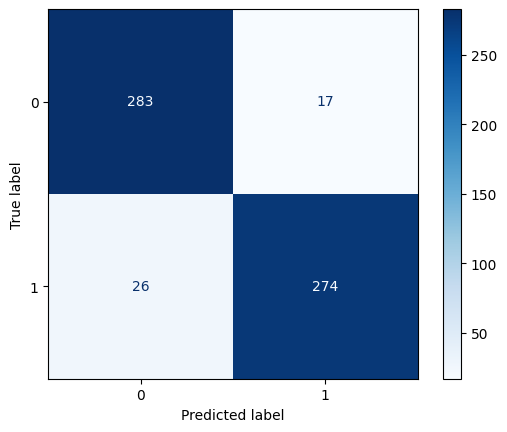

In [ ]:
# Output and save the confusion matrix
generate_confusion_matrix(test_set.dropna()['true_label'], test_set.dropna()['pred_label'].astype(int), 'mixed_reviews')

## **Test set 2. The Amazon dataset**

The sampled **Amazon** dataset we created above contains an equal number of reviews from each star rating. We will first filter out 3-star reviews, and then add a column for true_label, which we base on the star rating:
* 1 or 2 stars: true_label = 0 (negative sentiment)
* 4 or 5 stars: true_label = 1 (positive sentiment)

The model's accuracy as measured on the Amazon test set is a little under 85%. Again, we have a reasonable balance between false positives (55 texts) and false negatives (67 texts).


In [ ]:
amazon.shape

(1000, 3)

In [ ]:
amazon = amazon[amazon['star_rating'] != 3]

In [ ]:
amazon.head()

,text,star_rating,word_count
1,Looks exactly like the images on the site. Fit...,4,46
2,I gave these to my son as a gift and he liked ...,4,26
3,Waaaaaaay too long and the pattern of the fabr...,4,105
5,I saw these at a store and liked them but they...,4,118
6,These are great little shoes. They're well mad...,4,65


In [ ]:
amazon['true_label'] = amazon['star_rating'].apply(lambda x: 1 if x > 3 else 0)

<ipython-input-120-b20bbe78cd67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon['true_label'] = amazon['star_rating'].apply(lambda x: 1 if x > 3 else 0)


In [ ]:
amazon.head()

,text,star_rating,word_count,true_label
1,Looks exactly like the images on the site. Fit...,4,46,1
2,I gave these to my son as a gift and he liked ...,4,26,1
3,Waaaaaaay too long and the pattern of the fabr...,4,105,1
5,I saw these at a store and liked them but they...,4,118,1
6,These are great little shoes. They're well mad...,4,65,1


In [ ]:
%%time
# Add predictions
amazon = model_wrapper.add_predictions(amazon)

CPU times: user 22min 34s, sys: 25.1 s, total: 22min 59s
Wall time: 17min 36s


In [ ]:
amazon.head()

,text,star_rating,word_count,true_label,pred_prob,pred_label
1,Looks exactly like the images on the site. Fit...,4,46,1,0.500670,1.0
2,I gave these to my son as a gift and he liked ...,4,26,1,0.976287,1.0
3,Waaaaaaay too long and the pattern of the fabr...,4,105,1,0.290501,0.0
5,I saw these at a store and liked them but they...,4,118,1,0.323206,0.0
6,These are great little shoes. They're well mad...,4,65,1,0.961237,1.0


In [ ]:
# Calculate accuracy on the Amazon dataset
amazon_accuracy = accuracy_score(amazon.dropna()['true_label'], amazon.dropna()['pred_label'])
print(amazon_accuracy)

0.8475


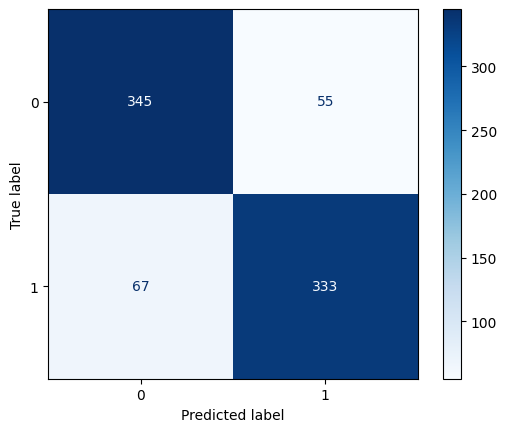

In [ ]:
# Output and save the confusion matrix
generate_confusion_matrix(amazon.dropna()['true_label'], amazon.dropna()['pred_label'], 'amazon_data')

# **Save Configs and Results**
I gather the configs and the results and save them to disk as a JSON object, thereby creating a record that remains after the runtime is destroyed.






## **Save the configs and results from the latest run**

In [ ]:
# Dictionary to hold the configs and results
configs_and_results = dict()

# General configs
configs_and_results['timestamp'] = timestamp.replace('_', ' ')
configs_and_results['amazon_sample_n'] = AMAZON_SAMPLES_N
configs_and_results['clean'] = CLEAN
configs_and_results['model'] = MODEL
configs_and_results['max_seq_length'] = MAX_SEQ_LENGTH
configs_and_results['n_folds'] = N_FOLDS
configs_and_results['lr'] = LR
configs_and_results['batch'] = BATCH
configs_and_results['epochs'] = EPOCHS
configs_and_results['patience'] = PATIENCE
configs_and_results['dropout'] = DROPOUT

# Set empty strings, to generate empty cells in the table, if they are not replaced below
configs_and_results['embedding_dim'] = ''
configs_and_results['max_vocab_size'] = ''
configs_and_results['architecture'] = ''
configs_and_results['first_lstm_layer'] = ''
configs_and_results['second_lstm_layer'] = ''
configs_and_results['attention'] = ''
configs_and_results['num_filters'] = ''
configs_and_results['kernel_size'] = ''

if MODEL in ['lstm', 'cnn']:
    configs_and_results['embedding_dim'] = EMBEDDING_DIM

if MODEL == 'lstm':
    configs_and_results['max_vocab_size'] = MAX_VOCAB_SIZE
    configs_and_results['architecture'] = ARCHITECTURE

    if ARCHITECTURE in ['one_layer', 'two_layer']:
        configs_and_results['first_lstm_layer'] = FIRST_LSTM_LAYER

    if ARCHITECTURE == 'two_layer':
        configs_and_results['second_lstm_layer'] = SECOND_LSTM_LAYER

    configs_and_results['attention'] = ATTENTION

if MODEL == 'cnn':
    configs_and_results['num_filters'] = NUM_FILTERS
    configs_and_results['kernel_size'] = KERNEL_SIZE

configs_and_results['portion_of_test_set_used'] = len(test_set.dropna()) / len(test_set)

configs_and_results['test_accuracy'] = test_accuracy

configs_and_results['portion_of_amazon_set_used'] = len(amazon.dropna()) / len(amazon)

configs_and_results['amazon_accuracy'] = amazon_accuracy

# Add final validation values to the dictionary
if MODEL in ['lstm', 'cnn', 'distilbert']:
    configs_and_results['val_acc'] = average_metrics['val_accuracy'][-1]
    configs_and_results['val_loss'] = average_metrics['val_loss'][-1]
    configs_and_results['val_precision'] = average_metrics['val_precision'][-1]
    configs_and_results['val_recall'] = average_metrics['val_recall'][-1]
    configs_and_results['val_f1'] = average_metrics['val_f1'][-1]

# File name for the config_and_results file
results_filename = f'results_{timestamp}.json'

# Generate a JSON object with the configs and the results.
with open(os.path.join(RESULTS_DIR, results_filename), 'w') as f:
    json.dump(configs_and_results, f, indent = 4)


## **Gather configs and results from all runs**
To make it easy to compare the results from all tested models, I load the JSON objects generated above and put them into one dataframe, which I save back to disk. This way I get the results from all runs, along with the configurations they were based on, in one table, which can easily be copied into a Google Sheet for further analysis.

In [ ]:
def aggregate_results():
    # List to store each run's data
    aggregated_results = []

    # Loop through each file in the base directory
    for file in os.listdir(RESULTS_DIR):
        json_file_path = os.path.join(RESULTS_DIR, file)

        # Only proceed if it's a JSON file that starts with "config_and_results"
        if file.startswith("results_") and file.endswith(".json"):
            # # Extract the date and time part from the file name
            # date_time_part = file.replace("results_", "").replace(".json", "")

            # Read the JSON file
            with open(json_file_path, 'r') as json_file:
                config_and_results = json.load(json_file)
                # config_and_results['date_time'] = date_time_part  # Add the date and time to the data
                aggregated_results.append(config_and_results)

    # Convert the list of dictionaries into a Pandas DataFrame
    aggregated_results_df = pd.DataFrame(aggregated_results)

    # Replace NaNs with empty strings, for pretty output
    aggregated_results_df = aggregated_results_df.fillna("")

    # Put the date_time column first
    # aggregated_results_df = aggregated_results_df[['date_time'] + [col for col in aggregated_results_df.columns if col != 'date_time']]

    # Sort dataframe by data_tiem
    aggregated_results_df.sort_values(by = 'timestamp', inplace = True)

    # File name for the summary file
    aggregated_results_filename = f'aggregated_results_{timestamp}.csv'

    # Save the dataframe to a CSV file
    aggregated_results_df.to_csv(os.path.join(RESULTS_DIR, aggregated_results_filename), index = False)

    # Print the table
    display(aggregated_results_df)

aggregate_results()

,timestamp,amazon_sample_n,clean,model,max_seq_length,n_folds,lr,batch,epochs,patience,...,kernel_size,portion_of_test_set_used,test_accuracy,portion_of_amazon_set_used,amazon_accuracy,val_acc,val_loss,val_precision,val_recall,val_f1
0,2024-11-24 1950,1000,False,textblob,30,5,0.00100,128,30,3,...,,0.763333,0.803493,0.778,0.658098,,,,,
1,2024-11-24 1952,1000,True,textblob,30,5,0.00100,128,30,3,...,,0.763333,0.805677,0.780,0.657692,,,,,
2,2024-11-24 1954,1000,True,lstm,30,5,0.00100,128,30,3,...,,1.000000,0.778333,0.800,0.677500,0.80625,0.434088,0.86128,0.733405,0.79216
3,2024-11-24 1958,1000,True,lstm,30,5,0.00100,128,30,3,...,,1.000000,0.775000,0.800,0.686250,0.783333,0.461132,0.873737,0.686508,0.768889
4,2024-11-24 2003,1000,True,lstm,30,5,0.00100,128,30,3,...,,1.000000,0.803333,0.800,0.715000,0.810417,0.466465,0.804348,0.800866,0.802603
5,2024-11-24 2009,1000,True,cnn,30,5,0.00100,128,30,3,...,3,1.000000,0.805000,0.800,0.725000,0.85625,0.359103,0.850622,0.861345,0.85595
6,2024-11-24 2014,1000,True,distilbert,30,5,0.00005,128,30,3,...,,1.000000,0.896667,0.800,0.788750,0.927083,0.277739,0.940697,0.910173,0.925042
7,2024-11-24 2101,1000,False,distilbert,30,5,0.00005,128,30,3,...,,1.000000,0.915000,0.800,0.845000,0.938542,0.245564,0.940012,0.931882,0.935925
8,2024-11-24 2207,1000,False,distilbert,30,5,0.00005,64,30,3,...,,1.000000,0.918333,0.800,0.840000,0.93125,0.261158,0.919831,0.943723,0.931624
9,2024-11-25 0637,1000,False,distilbert,30,5,0.00002,128,30,3,...,,1.000000,0.925000,0.800,0.840000,0.9375,0.219159,0.958716,0.908696,0.933036


# **Results and Discussion**

The table below shows the different models and configurations I tried, and their accuracy measured on two test sets.

Rows 1 and 2 show the TextBlob accuracy, row 1 with no cleaning of the texts, and row 2 with basic cleaning (removing non-alpha characters, and lowercasing the text). As can be seen, on the cleaned texts, TextBlob achieved an accuracy on the hold-out test set from the **mixed-reviews** dataset of 80.8%, wheras the accuracy on the **Amazon** test set was just 65.8%.

The best of my deep learning models was the DistilBert model, with the learning rate set to 0.00002. It achieved an accuracy on the hold-out **mixed_reviews** test set of 92,8%, and on the **Amazon** dataset of 84.8%. That is, the DistilBert model was on average, over these two test sets, 15.6 points better than TextBlob. And that is in spite of the fact that TextBlob labeled some texts as neutral, even though all texts in the test sets should be either positive or negative. Any text labeled as neutral by TextBlob was excluded, and this should have helped TextBlob. The DistilBERT model dutifully labeled all texts given to it as either negative or positive.








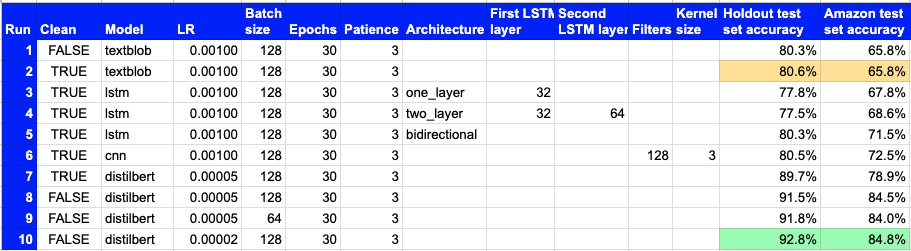

So does that mean that I can now launch my DistilBERT-based text-sentiment analysis tool and put TextBlob out of business?

Well, not quite. It must be admitted that TextBlob is a ready-made tool that can be applied to any text set. My DistilBERT model, on the other hand, had the benefit of being evaluated on reviews very similar to those that it was trained on; it was tested on unseen data, as is appropriate, but unseen data of the same kind it had learned from. If we took the DistilBERT model that was trained on this dataset and tested it on some ofther kind of texts, such as tweets or newspaper articles, it's likely that it would do much worse, since sentiments in those texts might be expressed somewhat differently than in the customer reviews that our model was trained on. For TextBlob, on the other hand, there is no reason to think that it would necessarily perform worse on any other data than it did on these reviews. So TextBlob remains safe from my challenge.

What can be said though, is that if you want to perform sentiment analysis on a set of some specific kind of texts and have access to (or have the resources to generate) a large enough number of labeled samples, then it's quite possible that you can build a machine-learing model that will outperform TextBlob on that particular kind of texts. After all, the 15.6 point margin by which I beat TextBlob is pretty resounding.

## **Ideas for future work**
As suggested above, it would be interesting to test a DistilBERT model trained on one particular kind of texts, e.g. the reviews I used, and then test it on texts of another kind, to see how much the performance would suffer.

It would also be interesting to conduct a more thorough search of the architecture and hyper-parameter space for the LSTM and CNN models, to see if their performance could be brought closer to that of the DistilBERT model. Those models have the advantage over DistilBERT that they are much faster to train.

